<a href="https://colab.research.google.com/github/shokoufehnaseri/Text-Mining/blob/main/text_mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Sentiment Analysis of Stock-Related Tweets**</center>

## 1. Introduction

### 1.1. Purpose of the Project

The objective of this project is to analyze sentiment trends in stock-related tweets and assess their potential influence on stock market movements. By leveraging natural language processing (NLP) techniques, we aim to classify tweets into positive, neutral, and negative sentiments and compare the performance of different text classification models.

### 1.2. Main Assumptions

- Tweets containing specific stock-related keywords reflect market sentiment.

- Sentiment classification can be performed accurately using machine learning models.

- Pre-trained transformer models (e.g., FinBERT) can provide higher accuracy compared to traditional classifiers.

## 2. Data
### 2.1. Description of the Dataset

- The Twitter raw data was downloaded using the Twitter REST API search, specifically the "Tweepy (version 3.8.0)" Python package, which simplifies the interaction between the REST API and developers. The Twitter REST API retrieves data from the past seven days and allows filtering by language. The tweets were filtered for the English (en) language.

- The dataset was collected between April 9 and July 16, 2020.Tweets were filtered based on keywords: #SPX500, #SP500, SPX500, SP500, $SPX, #stocks, $MSFT, $AAPL, $AMZN, $FB, $BBRK.B, $GOOG, $JNJ, $JPM, $V, $PG, $MA, $INTC, $UNH, $BAC, $T, $HD, $XOM, $DIS, $VZ, $KO, $MRK, $CMCSA, $CVX, $PEP, $PFE. Due to the large volume of data, We stored only each tweet's content and creation date.

- The dataset consists of 943,672 tweets, with a randomly sampled subset of 5,000 tweets for analysis. Among them, 1,300 tweets were manually labeled, and the remaining 3,700 were unlabeled.

***Importing Libraries***

In [124]:
import pandas as pd
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from nltk import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hoangnhu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2.2. Loading Dataset

In [133]:
tweet_data = pd.read_csv("/Users/hoangnhu/Desktop/AI/Text-Mining_project/Tweets/tweets_labelled_09042020_16072020.csv", delimiter=";")

#### ***Inspect the Data***

Check for issues like missing values or incorrectly formatted columns.


In [63]:
tweet_data.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [64]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   created_at  5000 non-null   object
 2   text        5000 non-null   object
 3   sentiment   1300 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [65]:
tweet_data['sentiment'].value_counts()

sentiment
positive    528
neutral     424
negative    348
Name: count, dtype: int64

In [66]:
print(tweet_data.isnull().sum())

id               0
created_at       0
text             0
sentiment     3700
dtype: int64


The dataset consists of 5,000 observations. Among these, 1,300 observations are labeled with sentiments as 'positive', 'negative', or 'neutral', while the remaining 3,700 observations are unlabeled, with their sentiment marked as `NaN`.

#### ***Clean the Text Data***

In [67]:
tweet_data['text']

0       RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...
1       #SriLanka surcharge on fuel removed!\n⛽📉\nThe ...
2       Net issuance increases to fund fiscal programs...
3       RT @bentboolean: How much of Amazon's traffic ...
4       $AMD Ryzen 4000 desktop CPUs looking ‘great’ a...
                              ...                        
4995    With ad revenues falling, what’s the impact on...
4996    RT @KelvinSCWong: Well another point to add to...
4997    $ITOX working on a contract with a fortune 500...
4998    $DIS it could break the 120 pin, then 125&gt; ...
4999    Amedisys Inc $AMED COO Christopher Gerard Sell...
Name: text, Length: 5000, dtype: object


As observed, raw text data often contains noise and inconsistencies that can impede accurate sentiment analysis. To address this, preprocessing is an essential step to clean, standardize, and structure the data, ensuring its suitability for machine learning algorithms. The following steps are commonly employed to prepare textual data effectively:

*Lowercasing:* All text is converted to lowercase to ensure uniformity and avoid treating the same word differently due to capitalization (e.g., "Happy" vs. "happy").

*Removal of URLs:* Text often contains hyperlinks that do not contribute to the sentiment of the content. These are removed to reduce noise.

*Remove Mentions:* Mentions, typically denoted by the @ symbol followed by a username (e.g., @user), are common in social media text. While they indicate a reference to another user, they usually do not contribute to the sentiment of the text and are removed to reduce noise.

*Handling Hashtags:* Hashtags are common in social media text. While the # symbol is removed, the associated words are retained, as they may provide context or sentiment-related information.

*Removal of Numeric and Punctuation Data:* Numbers and punctuation marks, unless contextually relevant, are removed to simplify the text.

Perform text preprocessing to ensure consistency and remove noise.

## 3. Data Preprocessing

In [68]:
import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters

    return text
tweet_data['cleaned_text'] = tweet_data['text'].apply(lambda x: clean_text(x))

In [69]:
tweet_data

,id,created_at,text,sentiment,cleaned_text
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,rt yo\nenter to win monarch tokens\n\nus sto...
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,surcharge on fuel removed\n\nthe surcharge of...
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,net issuance increases to fund fiscal programs...
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,rt how much of amazons traffic is served by f...
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,amd ryzen desktop cpus looking great and on t...
...,...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN,with ad revenues falling whats the impact on s...
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN,rt well another point to add to dent the curr...
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN,itox working on a contract with a fortune aer...
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN,dis it could break the pin then gt above


In [70]:
# Split into labeled and unlabeled data
#labeled_data = tweet_data[tweet_data["sentiment"].notna()]
#unlabeled_data = tweet_data[tweet_data["sentiment"].isna()]

In [71]:
#labeled_data.info()

### **3.1. Tokenize the Text**
Tokenization is the process of splitting text into smaller units, called tokens, which are often individual words. This step is essential for text preprocessing as it enables the analysis of each word separately. For example, the sentence "I love programming!" would be tokenized into ['I', 'love', 'programming', '!'].

In Python, the word_tokenize function from the nltk library is commonly used for this purpose. It efficiently breaks a sentence into tokens, taking care of punctuation and special characters, allowing for precise text analysis.

Split the cleaned text into individual words.

In [72]:
tweet_data['tokens'] = tweet_data['cleaned_text'].apply(word_tokenize)
#labeled_data['tokens'] = labeled_data['cleaned_text'].apply(word_tokenize)

The following code calculates the number of words in each entry of the dataset and identifies the minimum and maximum word counts. This analysis provides a better understanding of the text length distribution, offering valuable insights into the variability of the data prior to further processing.

In [73]:
tweet_data['n_word'] = [len(str(row['tokens']).split()) for _, row in tweet_data.iterrows()]

print("minimum number of words: ", min(tweet_data['n_word']))
print( "maximum number of words ", max(tweet_data['n_word']))

#labeled_data['n_word'] = [len(str(row['tokens']).split()) for _, row in labeled_data.iterrows()]

#print(min(labeled_data['n_word']), 
#max(labeled_data['n_word']))

minimum number of words:  1
maximum number of words  59


### **3.2. Remove Stop Words**
Remove common words that don't contribute to sentiment.

In [111]:
from nltk.corpus import stopwords

# General English stop words
general_stop_words = set(stopwords.words('english'))

# Define custom stopwords
custom_stopwords = set([
    'SP500', 'S&P', '500', 'index', 'stock', 'market', 'stocks',
    'trading', 'finance', 'investing', 'investor', 'business',
    "billion", 'price', 'StockMarket', 'share',
    'RT', 'http','dollar','dollars', 'percent', 'https', 'www', 'bit.ly', '@username', '#finance',
    'breaking', 'update', 'today', 'yesterday', 'tomorrow',  "aapl", "msft", "amzn", "tsla", "googl", "meta", "nvda", "brk.b", "jnj", "pg", 
    "v", "unh", "hd", "ma", "pep", "bac", "xom", "ko", "abbv", "avgo", "cost", 
    "mcd", "csco", "pfe", "cvx", "adbe", "mrk", "nflx", "dis", "intc", "wmt", 
    "tmo", "orcl", "crm", "nke", "wfc", "acn", "lin", "mdt", "txn", "dhr", "hon", 
    "lly", "vz", "schw", "amgn", "ibm", "t", "qcom", "sbux", "mmm", "gs", "rtx", 
    "ups", "low", "bmy", "cat", "spgi", "isrg", "c", "elv", "lmt", "mo", "bkng", 
    "adp", "amd", "de", "pm", "gild", "syk", "ge", "amt", "ms", "blk", "cci", 
    "cvs", "now", "intu", "ci", "zts", "eqix", "ice", "tgt", "mu", "fis", "ew", 
    "cb", "mmc", "apd", "cl", "so", "pgr", "duke", "pld", "aon", "fisv", "itw", 
    "stz", "regn", "adi", "hum", "exc", "pxd", "snps", "cop", "kdp", "kmb", "rop", 
    "etn", "aep", "eog", "mar", "atvi", "noc", "pru", "oxy", "orly", "d", "chrw", 
    "bax", "adm", "fdx", "aig", "dg", "tsco", "qqq", "fb", "spx", "spy","new", "day", "week", "rt", "amp"
])

# Combine general_stop_words with custom stopwords
combined_stopwords = general_stop_words.union(custom_stopwords)

# Remove stopwords function
def remove_stopwords(text, stopwords):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return " ".join(filtered_words)

# Apply the function to the 'text' column
tweet_data['final_text'] = tweet_data['cleaned_text'].apply(lambda x: remove_stopwords(x, combined_stopwords))


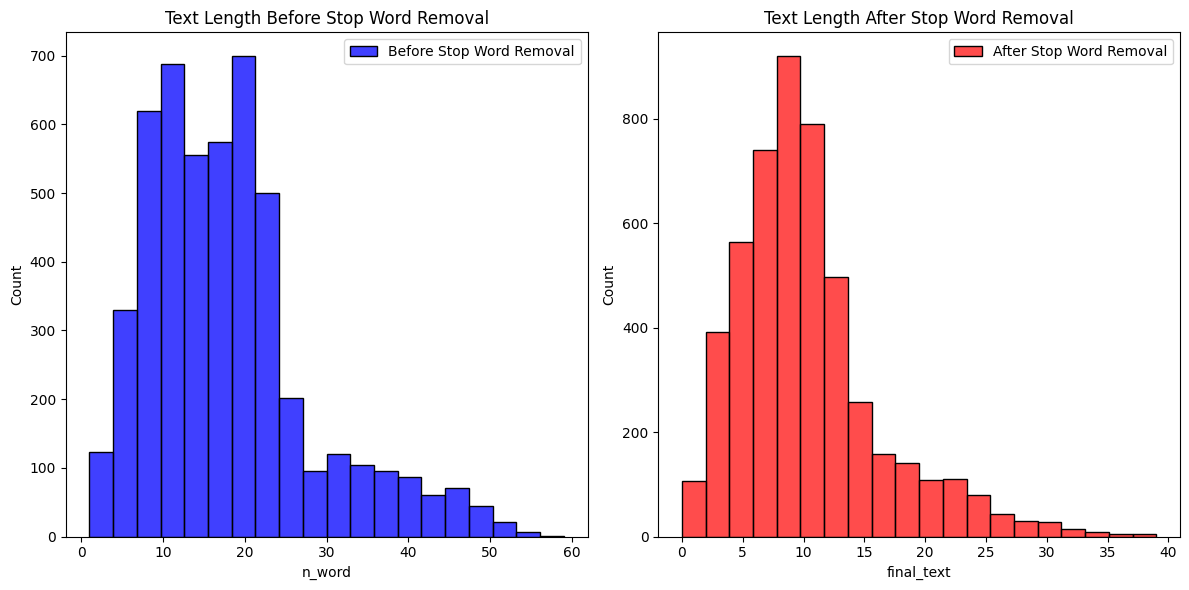

In [112]:
# Visualize text length distribution before and after cleaning
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(tweet_data['n_word'], bins=20, color='blue', label='Before Stop Word Removal')
plt.title('Text Length Before Stop Word Removal')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(tweet_data['final_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0), bins=20, color='red', label='After Stop Word Removal', alpha=0.7)
plt.title('Text Length After Stop Word Removal')
plt.legend()

plt.tight_layout()  # Adjust subplot params for a tight layout
plt.show()

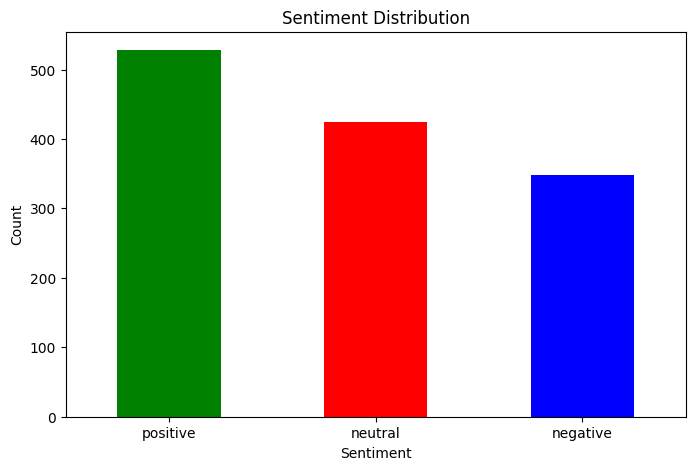

In [113]:
# Count sentiment occurrences
sentiment_counts = tweet_data['sentiment'].value_counts()

# Plot sentiment distribution
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'], figsize=(8, 5))
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


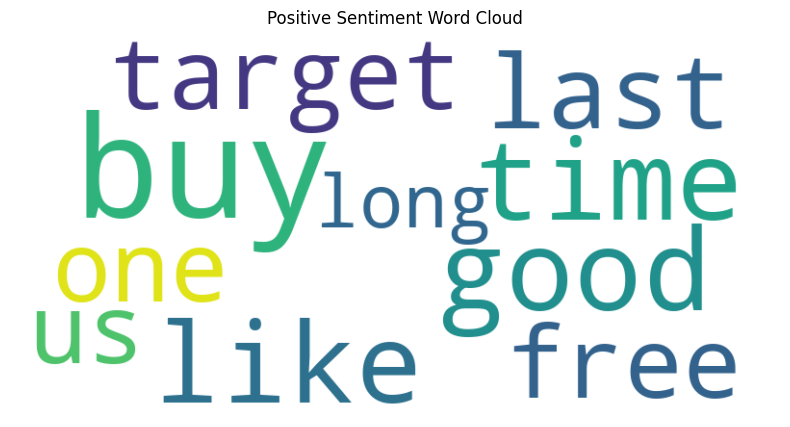

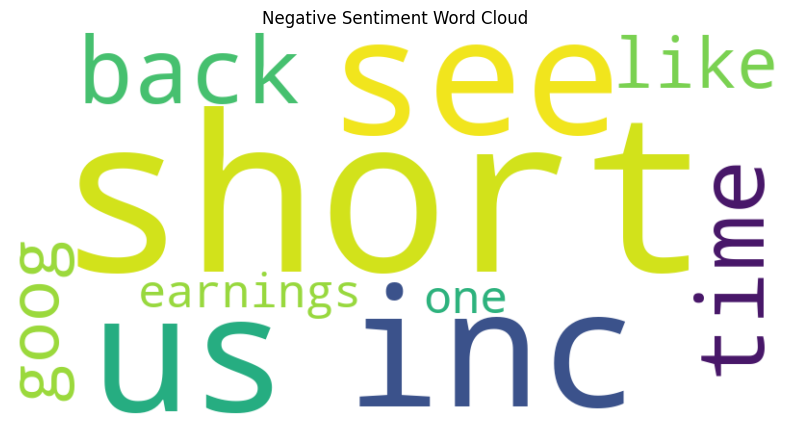

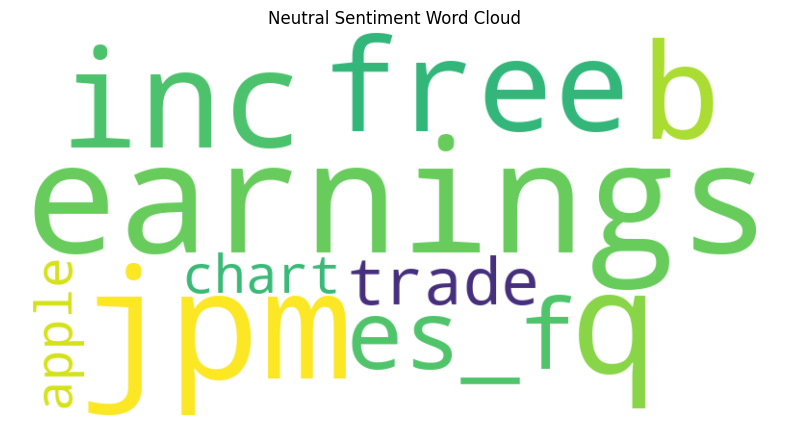

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Assuming tweet_data is your DataFrame and it has been defined

# Filter for positive, negative, and neutral sentiment and combine text
positive_text = " ".join(tweet_data[tweet_data['sentiment'] == 'positive']['final_text'])
negative_text = " ".join(tweet_data[tweet_data['sentiment'] == 'negative']['final_text'])
neutral_text = " ".join(tweet_data[tweet_data['sentiment'] == 'neutral']['final_text'])

# Function to generate word cloud for the top N common words
def generate_wordcloud(text, title, top_n=10):
    # Tokenize the text and count word frequencies
    words = text.split()
    word_counts = Counter(words)
    
    # Get the most common words
    common_words = dict(word_counts.most_common(top_n))
    
    # Create a word cloud from the common words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for positive, negative, and neutral texts
generate_wordcloud(positive_text, 'Positive Sentiment Word Cloud')
generate_wordcloud(negative_text, 'Negative Sentiment Word Cloud')
generate_wordcloud(neutral_text, 'Neutral Sentiment Word Cloud')

 --> see just for 1 word -> difficult to understand .... try N-gram with 2-3 to clearly

In [123]:
# Define function to extract bigrams/trigrams
def extract_ngrams(corpus, ngram_range=(1, 3), max_features=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    ngrams_matrix = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    
    return ngrams

# Combine cleaned reviews for n-grams analysis
ngrams2 = extract_ngrams([positive_text], ngram_range=(2, 4), max_features=20)
print("\nExtracted bi-grams/tri-gram:")
print(ngrams2)


Extracted bi-grams/tri-gram:
['buy buy' 'dataswarm markets' 'dataswarm markets information'
 'dataswarm markets information dataswarm' 'detected noticeable'
 'detected noticeable rise' 'detected noticeable rise zeitgeist'
 'doesnt matter' 'information dataswarm' 'information dataswarm ref'
 'long term' 'looks like' 'markets information'
 'markets information dataswarm' 'short term' 'target raised' 'time highs'
 'unitedhealth group' 'visit dataswarm markets'
 'visit dataswarm markets information']


##  4. Vader sentiment analysis

In [86]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()


# Function to apply VADER sentiment analysis
def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    # Return compound score and label
    compound_score = scores["compound"]
    if compound_score >= 0.05:
        sentiment_label = "positive"
    elif compound_score <= -0.05:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    return pd.Series([compound_score, sentiment_label])

# Apply VADER sentiment analysis to final_text
tweet_data[["vader_score", "vader_sentiment"]] = tweet_data["final_text"].apply(analyze_sentiment)


In [87]:
# Display results
tweet_data["vader_sentiment"]

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
4995    positive
4996    positive
4997     neutral
4998    positive
4999    positive
Name: vader_sentiment, Length: 5000, dtype: object

In [88]:
tweet_data

,id,created_at,text,sentiment,cleaned_text,tokens,n_word,final_text,text_length_before,text_length_after,vader_score,vader_sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,rt yo\nenter to win monarch tokens\n\nus sto...,"[rt, yo, enter, to, win, monarch, tokens, us, ...",22,yo enter win monarch tokens us crashes amp lea...,22,13,0.5859,positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,surcharge on fuel removed\n\nthe surcharge of...,"[surcharge, on, fuel, removed, the, surcharge,...",31,surcharge fuel removed surcharge rs imposed di...,31,20,0.2023,positive
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,net issuance increases to fund fiscal programs...,"[net, issuance, increases, to, fund, fiscal, p...",33,net issuance increases fund fiscal programs gt...,33,22,0.0516,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,rt how much of amazons traffic is served by f...,"[rt, how, much, of, amazons, traffic, is, serv...",22,much amazons traffic served fastly help us fin...,22,12,0.3818,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,amd ryzen desktop cpus looking great and on t...,"[amd, ryzen, desktop, cpus, looking, great, an...",12,ryzen desktop cpus looking great track launch,12,7,0.6249,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN,with ad revenues falling whats the impact on s...,"[with, ad, revenues, falling, whats, the, impa...",29,ad revenues falling whats impact social media ...,29,16,0.7269,positive
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN,rt well another point to add to dent the curr...,"[rt, well, another, point, to, add, to, dent, ...",21,well another point add dent current optimism h...,21,13,0.6808,positive
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN,itox working on a contract with a fortune aer...,"[itox, working, on, a, contract, with, a, fort...",49,itox working contract fortune aerospace firm x...,49,33,0.0000,neutral
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN,dis it could break the pin then gt above,"[dis, it, could, break, the, pin, then, gt, ab...",9,could break pin gt,9,4,0.2732,positive


In [89]:
# Split into labeled and unlabeled data
labeled_data = tweet_data[tweet_data["sentiment"].notna()]
unlabeled_data = tweet_data[tweet_data["sentiment"].isna()]

In [90]:
# Add a new column to indicate whether the sentiments match
labeled_data["comparison"] = labeled_data["sentiment"] == labeled_data["vader_sentiment"]

# Calculate the number of matches
matches = labeled_data["comparison"].sum()

# Calculate total number of rows
total = len(labeled_data)

# Calculate accuracy
accuracy = (matches / total) * 100

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 68.69%


/var/folders/wk/_skfb8h51s78m4tb9r4ypk540000gn/T/ipykernel_22934/3118178342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data["comparison"] = labeled_data["sentiment"] == labeled_data["vader_sentiment"]


### **6. Lemmatization or Stemming**
Reduce words to their base forms.

In [91]:
tweet_data.head()

,id,created_at,text,sentiment,cleaned_text,tokens,n_word,final_text,text_length_before,text_length_after,vader_score,vader_sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,rt yo\nenter to win monarch tokens\n\nus sto...,"[rt, yo, enter, to, win, monarch, tokens, us, ...",22,yo enter win monarch tokens us crashes amp lea...,22,13,0.5859,positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,surcharge on fuel removed\n\nthe surcharge of...,"[surcharge, on, fuel, removed, the, surcharge,...",31,surcharge fuel removed surcharge rs imposed di...,31,20,0.2023,positive
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,net issuance increases to fund fiscal programs...,"[net, issuance, increases, to, fund, fiscal, p...",33,net issuance increases fund fiscal programs gt...,33,22,0.0516,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,rt how much of amazons traffic is served by f...,"[rt, how, much, of, amazons, traffic, is, serv...",22,much amazons traffic served fastly help us fin...,22,12,0.3818,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,amd ryzen desktop cpus looking great and on t...,"[amd, ryzen, desktop, cpus, looking, great, an...",12,ryzen desktop cpus looking great track launch,12,7,0.6249,positive


### **7. Encode Sentiment Labels**
Convert sentiment labels (e.g., "positive", "negative") into numeric values for machine learning models.

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
tweet_data['sentiment_encoded'] = label_encoder.fit_transform(tweet_data['vader_sentiment'])

### **8. Prepare Data for Modeling**
Split the data into training and testing sets.

In [32]:
from sklearn.model_selection import train_test_split

X = tweet_data['cleaned_text']
y = tweet_data['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **9. Vectorize Text Data**
Convert text into numerical form using techniques like TF-IDF or Count Vectorization.

In [48]:
#X_train = [" ".join(doc) if isinstance(doc, list) else doc for doc in X_train]
#X_test = [" ".join(doc) if isinstance(doc, list) else doc for doc in X_test]


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### **10. Ready for Sentiment Analysis**
You can now use your processed data with machine learning models or sentiment analysis tools.

For example, using a logistic regression model:

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.27      0.42       161
           1       0.70      0.89      0.78       391
           2       0.80      0.81      0.81       448

    accuracy                           0.76      1000
   macro avg       0.80      0.66      0.67      1000
weighted avg       0.78      0.76      0.74      1000



In [35]:
# Create a DataFrame
df = pd.DataFrame({'Predicted': y_pred, 'Actual': y_test})

# Print the DataFrame as a table
print(df)

      Predicted  Actual
1501          1       1
2586          1       1
2653          2       2
1055          1       1
705           2       2
...         ...     ...
4711          2       2
2313          2       2
3214          0       2
2732          2       2
1926          1       2

[1000 rows x 2 columns]


### **Vader classification**

In [36]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shokoufeh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### ***SVM Classifier***

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# Train SVM classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_svm = svm_clf.predict(X_test_tfidf)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.40      0.52       161
           1       0.70      0.90      0.79       391
           2       0.84      0.77      0.81       448

    accuracy                           0.76      1000
   macro avg       0.76      0.69      0.70      1000
weighted avg       0.77      0.76      0.75      1000

SVM Accuracy: 0.762


###  ***Naive Bayes Classifier***

In [38]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_nb = nb_clf.predict(X_test_tfidf)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.11      0.19       161
           1       0.70      0.63      0.67       391
           2       0.62      0.87      0.73       448

    accuracy                           0.66      1000
   macro avg       0.74      0.54      0.53      1000
weighted avg       0.70      0.66      0.62      1000

Naive Bayes Accuracy: 0.656


### **Pre-trained Models**
For advanced analysis, we used transformer-based models like finBERT with libraries such as `transformers` from Hugging Face.

In [39]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [40]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
# Load the FinBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model_bert = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)
model_bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

In [73]:
tweet_data.head()

,id,created_at,Text,sentiment,cleaned_text,sentiment_encoded
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,yo enter win monarch tokens us crashes learn p...,2
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,surcharge fuel removed surcharge rs imposed di...,0
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,net issuance increases fund fiscal programs gr...,2
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,much amazons traffic served fastly help us fin...,2
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,ryzen desktop cpus looking great track launch,2


In [43]:
# Preprocess the data
tweets = tweet_data["cleaned_text"].values
labels = tweet_data["sentiment_encoded"].values

In [44]:
# Tokenize the tweets
def encode_tweets(tweets, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


In [45]:
# Encode tweets
input_ids, attention_masks = encode_tweets(tweets, tokenizer)

In [46]:
# Split into train and test sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

In [47]:
# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

C:\Users\Shokoufeh\AppData\Local\Temp\ipykernel_9688\217390848.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\Shokoufeh\AppData\Local\Temp\ipykernel_9688\217390848.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs)
C:\Users\Shokoufeh\AppData\Local\Temp\ipykernel_9688\217390848.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
C:\Users\Shokoufeh\AppData\Local\Temp\ipykernel_9688\217390848.py:5: UserWarn

In [48]:
# Create DataLoaders
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [49]:
# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [51]:
import torch.nn as nn

# Define the loss function
loss_fn = nn.CrossEntropyLoss()


In [52]:
# Training loop
def train():
    model_bert.train()
    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device).long()  # Convert labels to LongTensor

            model_bert.zero_grad()
            outputs = model_bert(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {total_loss / len(train_dataloader)}")
        scheduler.step()


In [53]:
def evaluate():
    model_bert.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model_bert(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.append(b_labels.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    print("Accuracy:", accuracy_score(true_labels, predictions))
    print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"]))


In [54]:
# Run training and evaluation
train()
evaluate()

Epoch 1/4 | Loss: 1.0540175390243531
Epoch 2/4 | Loss: 0.586809101819992
Epoch 3/4 | Loss: 0.31523855816572904
Epoch 4/4 | Loss: 0.12900617661699654
Accuracy: 0.784
              precision    recall  f1-score   support

    Negative       0.65      0.64      0.65       161
     Neutral       0.84      0.75      0.79       391
    Positive       0.79      0.87      0.83       448

    accuracy                           0.78      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.79      0.78      0.78      1000

